<a href="https://colab.research.google.com/github/Token-05/FACERecognition/blob/main/facerecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -U keras 
!pip install tensorflow
!pip list

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.11.0 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 69.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      Successfully uninstalled keras-2.11.0
Package                       Version
----------------------------- --

In [3]:
# 用いるライブラリ
# 入力処理系
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
# ネットワーク系
import torch.nn as nn
import torch
import tensorflow as tf
from keras import models
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, ELU, concatenate, GlobalAveragePooling2D, Input, BatchNormalization, SeparableConv2D, Subtract, concatenate, Conv2D, AveragePooling2D
from keras.activations import relu, softmax
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping

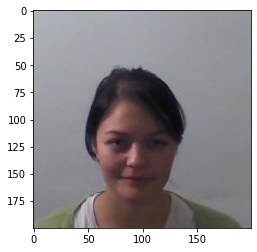

In [4]:
# データセット作成
class CreateDataset:
  # 初期化
  def __init__(self):
    pass
  
  # 同一人物の画像カップル
  def create_couple_rgbd(self, folder_name):
    # ファイルパス
    if folder_name == 'train': under_vap_path, under_cap_path = random.randint(1, 40), random.sample(list(range(1,101)),2)
    elif folder_name == 'val': under_vap_path, under_cap_path = random.randint(41, 49), random.sample(list(range(1,101)),2)
    elif folder_name == 'test': under_vap_path, under_cap_path = random.randint(50, 51), random.sample(list(range(1,101)),2)
    # rgb(sync)
    im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path[0])))[160:360,200:400]
    im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path,under_cap_path[1])))[160:360,200:400]
    # d(sync)
    imd1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path,under_cap_path[0])))[160:360,200:400]
    imd2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path,under_cap_path[1])))[160:360,200:400]
    # 正規化
    im1_truth = (imd1-np.mean(imd1))/np.max(imd1)
    im2_truth = (imd2-np.mean(imd2))/np.max(imd2)
    # 元の画像がRGBなのでRGBDに作り替える
    full1 = np.zeros((200,200,4))
    full1[:,:,:3] = im1[:,:,:3]
    full1[:,:,3] = im1_truth
    full2 = np.zeros((200,200,4))
    full2[:,:,:3] = im2[:,:,:3]
    full2[:,:,3] = im2_truth
    return np.array([full1, full2])
  
  # 同一人物でない画像カップル
  def create_wrong_rgbd(self, folder_name):
    # ファイルパス
    if folder_name == 'train': under_vap_path, under_cap_path = random.sample(list(range(1,41)),2), random.sample(list(range(1,101)),2)
    elif folder_name == 'val': under_vap_path, under_cap_path = random.sample(list(range(41,50)),2), random.sample(list(range(1,101)),2)
    elif folder_name == 'test': under_vap_path, under_cap_path = [50,51], random.sample(list(range(1,101)),2)
    # rgb(sync)
    im1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[0],under_cap_path[0])))[160:360,200:400]
    im2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncRGB/{}.jpg'.format(under_vap_path[1],under_cap_path[1])))[160:360,200:400]
    # d(sync)
    imd1 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path[0],under_cap_path[0])))[160:360,200:400]
    imd2 = np.array(Image.open('/content/drive/MyDrive/ColabNotebooks/graduation_research/main/VAP_trimodal_reduced/{}/Cap/3/SyncD/{}.png'.format(under_vap_path[1],under_cap_path[1])))[160:360,200:400]
    # 正規化
    im1_truth = (imd1-np.mean(imd1))/np.max(imd1)
    im2_truth = (imd2-np.mean(imd2))/np.max(imd2)
    # 元の画像がRGBなのでRGBDに作り替える
    full1 = np.zeros((200,200,4))
    full1[:,:,:3] = im1[:,:,:3]
    full1[:,:,3] = im1_truth
    full2 = np.zeros((200,200,4))
    full2[:,:,:3] = im2[:,:,:3]
    full2[:,:,3] = im2_truth
    return np.array([full1, full2])
  
  # train data set (訓練データ)
  def generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('train').reshape((2,200,200,4)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('train').reshape((2,200,200,4)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y
  
  # val data set (検証用データ)
  def val_generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('val').reshape((2,200,200,4)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('val').reshape((2,200,200,4)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y
  
  # test data set (テスト用データ)
  def val_generator(self, batch_size):
    while 1:
      X=[]
      y=[]
      switch=True
      for _ in range(batch_size):
        if switch:
          X.append(self.create_couple_rgbd('test').reshape((2,200,200,4)))
          y.append(np.array([0.]))
        else:
          X.append(self.create_wrong_rgbd('test').reshape((2,200,200,4)))
          y.append(np.array([1.]))
        switch=not switch
      X = np.asarray(X)
      y = np.asarray(y)
      XX1=X[0,:]
      XX2=X[1,:]
      yield [X[:,0],X[:,1]],y

c = CreateDataset()
plt.imshow(c.create_wrong_rgbd('test')[1][:,:,:3].astype(np.int64))
plt.show()

In [5]:
# ユークリッド距離とサンプルの分類器
class Calc:
  # 初期化
  def __init__(self):
    pass

  # ユークリッド距離の導出(顔の類似度チェック)
  def euclidean_distance(self, inputs):
    assert len(inputs) == 2, 'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
  
  # 対となるサンプル同士の近傍・分離
  def contrastive_loss(self, y_true, y_pred):
    margin=1.0
    return K.mean((margin - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.0)))

In [6]:
# squeezenet
class Squeezenet:
  # 初期化
  def __init__(self):
    self.calc = Calc()
    self.euclidean_distance = self.calc.euclidean_distance
    self.contrastive_loss = self.calc.contrastive_loss
  
  # fire module
  def fire(self, x, squeeze=16, expand=64):
    # 拡張する前に絞り込み
    x = Conv2D(squeeze, (1,1), padding='valid', activation='relu')(x)
    # 特徴マップを絞り込んで拡張
    left = Conv2D(expand, (1,1), padding='valid', activation='relu')(x)
    # 同じサイズにしチャネル拡張
    right = Conv2D(expand, (3,3), padding='same', activation='relu')(x)
    # 結合
    x = concatenate([left, right], axis=3)
    return x
  
  # 畳み込み
  def convolution(self):
    # 畳み込み層
    img_input=Input(shape=(200,200,4))
    x = Conv2D(64, (5, 5), strides=(2, 2), padding='valid')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = self.fire(x, squeeze=16, expand=16)
    x = self.fire(x, squeeze=16, expand=16)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = self.fire(x, squeeze=32, expand=32)
    x = self.fire(x, squeeze=32, expand=32)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = self.fire(x, squeeze=48, expand=48)
    x = self.fire(x, squeeze=48, expand=48)
    x = self.fire(x, squeeze=64, expand=64)
    x = self.fire(x, squeeze=64, expand=64)
    x = Dropout(0.2)(x)
    x = Conv2D(512, (1, 1), padding='same')(x)
    out = Activation('relu')(x)
    modelsqueeze= Model(img_input, out)
    modelsqueeze.summary()
    # 平滑化して予測データを生成
    im_in = Input(shape=(200,200,4))
    x1 = modelsqueeze(im_in)
    x1 = Flatten()(x1)
    x1 = Dense(512, activation="relu")(x1)
    x1 = Dropout(0.2)(x1)
    x1 = BatchNormalization()(x1)
    feat_x = Dense(128, activation="linear")(x1)
    feat_x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(feat_x)
    model_top = Model(inputs = [im_in], outputs = feat_x)
    model_top.summary()
    # ユークリッド距離を算出
    im_in1 = Input(shape=(200,200,4))
    im_in2 = Input(shape=(200,200,4))
    feat_x1 = model_top(im_in1)
    feat_x2 = model_top(im_in2)
    lambda_merge = Lambda(self.euclidean_distance)([feat_x1, feat_x2])
    model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)
    model_final.summary()
    adam = Adam(learning_rate=0.001)
    model_final.compile(optimizer=adam, loss=self.contrastive_loss, metrics=['accuracy'])
    return model_final

In [7]:
# googlenet
class Googlenet:
  # 初期化
  def __init__(self):
    self.calc = Calc()
    self.euclidean_distance = self.calc.euclidean_distance
    self.contrastive_loss = self.calc.contrastive_loss
  
  # 基礎の畳み込み
  def basic_conv2d(self, x, filters, kernel_size, strides, padding):
    x = Conv2D(filters, kernel_size, strides, padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
  
  # InceptionModule
  def inception_module(self, x, reduce=16, expand=64):
    # 1x1
    conv1x1 = self.basic_conv2d(x, expand, (1,1), (1,1), 'valid')
    # 3x3
    conv3x3_reduce = self.basic_conv2d(x, reduce, (1,1), (1,1), 'valid')
    conv3x3 = self.basic_conv2d(conv3x3_reduce, expand, (3,3), (1,1), 'same')
    # 5x5
    conv5x5_reduce = self.basic_conv2d(x, reduce, (1,1), (1,1), 'valid')
    conv5x5 = self.basic_conv2d(conv5x5_reduce, expand, (5,5), (1,1), 'same')
    # プーリング層
    max_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = self.basic_conv2d(max_pool, expand, (1,1), (1,1), 'valid')
    # 結合層
    x = concatenate([conv1x1, conv3x3, conv5x5, pool_proj], axis=3)
    return x
  
  # 畳み込み
  def convolution(self):
    # 畳み込み層
    input=Input(shape=(200,200,4))
    x = self.basic_conv2d(input, 64, (7,7), (2,2), 'same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.basic_conv2d(x, 64, (1,1), (1,1), 'valid')
    x = self.basic_conv2d(x, 192, (3,3), (1,1), 'same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.inception_module(x, 16, 16)
    x = self.inception_module(x, 16, 16)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = self.inception_module(x, 32, 32)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    x = self.inception_module(x, 64, 64)
    x = self.inception_module(x, 64, 64)
    x = AveragePooling2D(pool_size=(1,1))(x)
    x = Activation('softmax')(x)
    # 平滑化して予測データを生成
    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(1000, activation="linear")(x)
    out = Flatten()(x)
    out = Dropout(0.2)(out)
    out = BatchNormalization()(out)
    out = Dense(128, activation="linear")(out)
    out = Lambda(lambda  x: K.l2_normalize(x,axis=1))(out)
    model = Model(inputs = input, outputs = out)
    model.summary()
    # ～ここまでGoogleNet
    # ユークリッド距離を算出
    im_in1 = Input(shape=(200,200,4))
    im_in2 = Input(shape=(200,200,4))
    feat_x1 = model(im_in1)
    feat_x2 = model(im_in2)
    lambda_merge = Lambda(self.euclidean_distance)([feat_x1, feat_x2])
    model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)
    model_final.summary()
    adam = Adam(learning_rate=0.001)
    model_final.compile(optimizer=adam, loss=self.contrastive_loss, metrics=['accuracy'])
    return model_final

In [8]:
class Resnet50:
  # 初期化
  def __init__(self):
    self.calc = Calc()
    self.euclidean_distance = self.calc.euclidean_distance
    self.contrastive_loss = self.calc.contrastive_loss
  
  # 基礎の畳み込み
  def basic_conv2d(self, x, filters, kernel_size, strides, padding):
    x = Conv2D(filters, kernel_size, strides, padding)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
  
  # identity block
  def identity_block(self, x, reduce=16, expand=64):
    identity = self.basic_conv2d(x, reduce, (1,1), (1,1), 'valid')
    identity = self.basic_conv2d(identity, reduce, (3,3), (1,1), 'same')
    identity = self.basic_conv2d(identity, expand, (1,1), (1,1), 'valid')
    y = concatenate([x, identity], axis=3)
    return y
  
  # conv block
  def conv_block(self, x, reduce=16, expand=64):
    identity = self.basic_conv2d(x, reduce, (1,1), (1,1), 'valid')
    identity = self.basic_conv2d(identity, reduce, (3,3), (1,1), 'same')
    identity = self.basic_conv2d(identity, expand, (1,1), (1,1), 'valid')
    origin = Conv2D(reduce, (1,1), (1,1), 'valid')(x)
    origin = BatchNormalization()(origin)
    x = concatenate([origin, identity], axis=3)
    return x
  
  # 畳み込み
  def convolution(self):
    # 畳み込み層
    input=Input(shape=(200,200,4))
    x = self.basic_conv2d(input, 64, (7,7), (2,2), 'same')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(x)
    # 2
    x = self.conv_block(x, 64, 256)
    x = self.identity_block(x, 64, 256)
    x = self.identity_block(x, 64, 256)
    # 3
    x = self.conv_block(x, 128, 512)
    x = self.identity_block(x, 128, 512)
    x = self.identity_block(x, 128, 512)
    x = self.identity_block(x, 128, 512)
    # 5
    x = self.conv_block(x, 256, 1024)
    x = self.identity_block(x, 256, 1024)
    x = self.identity_block(x, 256, 1024)
    x = self.identity_block(x, 256, 1024)
    x = self.identity_block(x, 256, 1024)
    x = self.identity_block(x, 256, 1024)
    # 2
    x = self.conv_block(x, 512, 2048)
    x = self.identity_block(x, 512, 2048)
    x = self.identity_block(x, 512, 2048)
    x = AveragePooling2D(pool_size=(1,1))(x)
    x = Activation('softmax')(x)
    # 平滑化して予測データを生成
    x = Flatten()(x)
    x = Dropout(0.7)(x)
    x = Dense(1000, activation="linear")(x)
    out = Flatten()(x)
    out = Dropout(0.2)(out)
    out = BatchNormalization()(out)
    out = Dense(128, activation="linear")(out)
    out = Lambda(lambda  x: K.l2_normalize(x,axis=1))(out)
    model = Model(inputs = input, outputs = out)
    model.summary()
    # ～ここまでResNet
    # ユークリッド距離を算出
    im_in1 = Input(shape=(200,200,4))
    im_in2 = Input(shape=(200,200,4))
    feat_x1 = model(im_in1)
    feat_x2 = model(im_in2)
    lambda_merge = Lambda(self.euclidean_distance)([feat_x1, feat_x2])
    model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)
    model_final.summary()
    adam = Adam(learning_rate=0.001)
    model_final.compile(optimizer=adam, loss=self.contrastive_loss, metrics=['accuracy'])
    return model_final

In [9]:
def show_graph(train_gen_size, val_gen_size, Net, modelFilename, steps_per_epoch, epochs, validation_steps):
  create_dataset = CreateDataset()
  network = Net
  gen = create_dataset.generator(train_gen_size)
  val_gen = create_dataset.val_generator(val_gen_size)
  model_final = Net.convolution()
  checkpoint = ModelCheckpoint(filepath = "/content/drive/MyDrive/ColabNotebooks/graduation_research/main/model_best/{}.h5".format(modelFilename),save_best_only=True)
  history = model_final.fit(gen, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data = val_gen, validation_steps=validation_steps, callbacks=[checkpoint])

  # Plot training & validation loss values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

  return model_final

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_20 (InputLayer)          [(None, 200, 200, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_245 (Conv2D)            (None, 98, 98, 64)   6464        ['input_20[0][0]']               
                                                                                                  
 batch_normalization_175 (Batch  (None, 98, 98, 64)  256         ['conv2d_245[0][0]']             
 Normalization)                                                                                   
                                                                                           

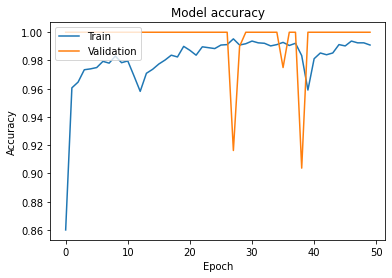

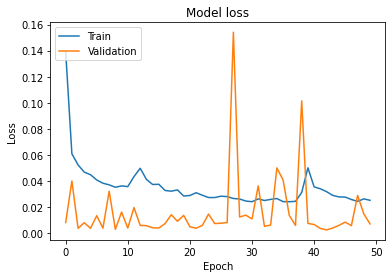

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 200, 200, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_271 (Conv2D)            (None, 100, 100, 64  12608       ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_177 (Batch  (None, 100, 100, 64  256        ['conv2d_271[0][0]']             
 Normalization)                 )                                                          

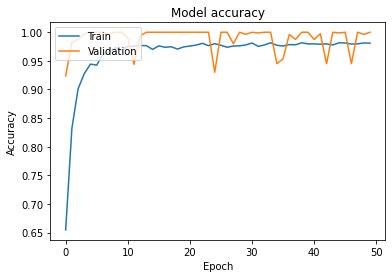

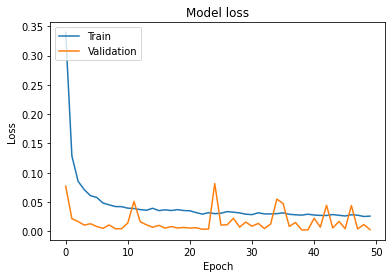

ResourceExhaustedError: ignored

In [ ]:
show_graph(32, 8, Squeezenet(), "squ", 100, 50, 100)
show_graph(32, 8, Googlenet(), "goo", 100, 50, 100)
show_graph(32, 8, Resnet50(), "res", 100, 50, 100)

In [12]:
show_graph(32, 8, Resnet50(), "res", 100, 50, 100)

ResourceExhaustedError: ignored